# Economic Resilience Predictor 

## Project Phase 1a: Data Acquisition - Madisson Project
This notebook handles the data collection phase for the economic resilience project. The Collection Phase is divided in two steps: Madisson Focused Collection (here)
and World Bank Collection (next step)

**Objectives:**
- Define Structure and Directories
- Collect historical economic data from Maddison Project using a refined data collection strategy focusing on:
- 38 high-quality countries (OECD + major emerging markets)
- Time period: 1990-2023
- Enhanced data quality and coverage
- Test and validation implemented to ensure data quality 

**Expected Outcomes:**
- Strong data coverage for target countries
- Good representation across shock periods
- Ready foundation for advanced feature engineering
 

In [2]:
# Focused Economic Data Collection 
# ==========================================================

# Environment Setup
import sys
import warnings
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
from datetime import datetime
import json

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', '{:.3f}'.format)

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Environment setup complete")
print(f"   - Working directory: {Path.cwd()}")
print(f"   - Python version: {sys.version.split()[0]}")

Environment setup complete
   - Working directory: /Users/laurarojas/Documents/DataScience/DS_CapstoneProjects/modern_economic_resilience
   - Python version: 3.10.13


In [3]:
# Load our focused configuration
# Using the file config.py saved in our directory we will define basic aspects of this analysis, to know: Focus Countries, Time Period, Major Shock covered and indicators 

sys.path.append("config")

try:
    from data_collection_config import *
    print("Configuration loaded successfully")
    print(f"   - Focus countries: {len(FOCUS_COUNTRIES)}")
    print(f"   - Time period: {START_YEAR}-{END_YEAR} ({ANALYSIS_YEARS} years)")
    print(f"   - Major shocks: {len(MAJOR_SHOCKS)}")
    print(f"   - WB indicators: {len(WORLD_BANK_INDICATORS)}")
    
    config_loaded = True
except ImportError as e:
    print(f"Configuration import failed: {e}")
    print("   Please ensure config/data_collection_config.py exists")
    config_loaded = False

Configuration loaded successfully
   - Focus countries: 38
   - Time period: 1990-2023 (34 years)
   - Major shocks: 5
   - WB indicators: 26


In [4]:
# Display configuration details


if config_loaded:
    print("TARGET COUNTRIES BY GROUP:")
    print("=" * 50)
    
    for group_name, countries in COUNTRY_GROUPS.items():
        print(f"\n{group_name.upper()} ({len(countries)} countries):")
        print(f"   {', '.join(countries)}")
    
    print(f"\nSHOCK PERIODS TO ANALYZE:")
    print("=" * 50)
    
    for shock_name, shock_info in MAJOR_SHOCKS.items():
        print(f"\n{shock_name.upper()}:")
        print(f"   Period: {shock_info['start']}-{shock_info['end']}")
        print(f"   Type: {shock_info['type']}")
        print(f"   Severity: {shock_info['severity']}")
        print(f"   Global impact: {shock_info['global_impact']}")
        if shock_info.get('regional_focus'):
            print(f"   Regional focus: {', '.join(shock_info['regional_focus'])}")

TARGET COUNTRIES BY GROUP:

DEVELOPED_OECD (20 countries):
   USA, GBR, FRA, DEU, JPN, CAN, AUS, ITA, ESP, NLD, BEL, CHE, SWE, NOR, DNK, FIN, AUT, IRL, NZL, PRT

EMERGING_MARKETS (18 countries):
   CHN, IND, BRA, RUS, MEX, IDN, TUR, KOR, THA, MYS, PHL, ZAF, POL, CZE, HUN, CHL, COL, ARG

HIGH_INCOME (10 countries):
   USA, GBR, FRA, DEU, JPN, CAN, AUS, CHE, SWE, NOR

UPPER_MIDDLE (9 countries):
   CHN, BRA, RUS, MEX, TUR, THA, MYS, POL, ARG

ASIAN_TIGERS (4 countries):
   KOR, THA, MYS, PHL

EUROPEAN_EMERGING (3 countries):
   POL, CZE, HUN

LATIN_AMERICA (5 countries):
   BRA, MEX, CHL, COL, ARG

SHOCK PERIODS TO ANALYZE:

ASIAN_FINANCIAL_CRISIS_1997:
   Period: 1997-1999
   Type: financial
   Severity: high
   Global impact: True
   Regional focus: THA, MYS, PHL, IDN, KOR

DOTCOM_RECESSION_2001:
   Period: 2001-2002
   Type: financial
   Severity: medium
   Global impact: True
   Regional focus: USA, GBR, DEU, JPN

GLOBAL_FINANCIAL_CRISIS_2008:
   Period: 2008-2010
   Type: financial


In [5]:

# Maddison data collection
# =====================================
# First formal step on data collection process, access the repository for the Madisson Project and extract the information 
# applying filters according to our focus: time period and countries

print(" TESTING MADDISON DATA COLLECTION")
print("=" * 50)

def collect_and_analyze_maddison():
    """Collect and analyze Maddison data with detailed reporting."""
    
    try:
        # Download Maddison data
        print("Downloading Maddison Project Database...")
        maddison_url = "https://dataverse.nl/api/access/datafile/421302"
        
        start_time = time.time()
        maddison_df = pd.read_excel(maddison_url, sheet_name='Full data')
        download_time = time.time() - start_time
        
        print(f"   Downloaded in {download_time:.1f} seconds")
        print(f"   Raw data shape: {maddison_df.shape}")
        print(f"   Columns: {list(maddison_df.columns)}")
        
        # Standardize column names
        column_mapping = {
            'countrycode': 'country_code',
            'country': 'country_name',
            'year': 'year',
            'gdppc': 'gdp_per_capita',
            'pop': 'population'
        }
        
        maddison_df.columns = [column_mapping.get(col.lower(), col.lower()) for col in maddison_df.columns]
        
        # Filter to our focus
        print(f"\nFiltering to focus countries and period...")
        maddison_filtered = maddison_df[
            (maddison_df['year'] >= START_YEAR) & 
            (maddison_df['year'] <= END_YEAR) &
            (maddison_df['country_code'].isin(FOCUS_COUNTRIES))
        ].copy()
        
        print(f"   Filtered data shape: {maddison_filtered.shape}")
        print(f"   Countries captured: {maddison_filtered['country_code'].nunique()}")
        print(f"   Year range: {maddison_filtered['year'].min()}-{maddison_filtered['year'].max()}")
        
        return maddison_filtered
        
    except Exception as e:
        print(f"   ERROR!: {e}")
        return None

# Run the collection
maddison_data = collect_and_analyze_maddison()

 TESTING MADDISON DATA COLLECTION
   Downloaded in 9.9 seconds
   Raw data shape: (131144, 6)
   Columns: ['countrycode', 'country', 'region', 'year', 'gdppc', 'pop']

Filtering to focus countries and period...
   Filtered data shape: (1254, 6)
   Countries captured: 38
   Year range: 1990-2022


In [6]:

# Analyze country coverage in detail
# These steps allows us to confirm the number of countries covered with the data collected from Madisson


if maddison_data is not None:
    print("COUNTRY COVERAGE ANALYSIS")
    print("=" * 40)
    
    # Countries found vs expected
    countries_found = set(maddison_data['country_code'].unique())
    countries_expected = set(FOCUS_COUNTRIES)
    countries_missing = countries_expected - countries_found
    
    print(f"Found: {len(countries_found)}/{len(countries_expected)} countries")
    print(f"Coverage rate: {len(countries_found)/len(countries_expected):.1%}")
    
    if countries_missing:
        print(f"\n Missing countries: {sorted(list(countries_missing))}")
    
    # Coverage by country group
    print(f"\nCOVERAGE BY COUNTRY GROUP:")
    print("-" * 40)
    
    group_coverage = {}
    for group_name, group_countries in COUNTRY_GROUPS.items():
        found_in_group = [c for c in group_countries if c in countries_found]
        coverage_rate = len(found_in_group) / len(group_countries)
        group_coverage[group_name] = {
            'found': len(found_in_group),
            'total': len(group_countries),
            'rate': coverage_rate,
            'missing': [c for c in group_countries if c not in countries_found]
        }
        
        print(f"{group_name}: {len(found_in_group)}/{len(group_countries)} ({coverage_rate:.1%})")
        if group_coverage[group_name]['missing']:
            print(f"   Missing: {group_coverage[group_name]['missing']}")
    
    print(f"Country coverage analysis complete!")
else:
    print(" Cannot analyze coverage - data collection failed")

COUNTRY COVERAGE ANALYSIS
Found: 38/38 countries
Coverage rate: 100.0%

COVERAGE BY COUNTRY GROUP:
----------------------------------------
developed_oecd: 20/20 (100.0%)
emerging_markets: 18/18 (100.0%)
high_income: 10/10 (100.0%)
upper_middle: 9/9 (100.0%)
asian_tigers: 4/4 (100.0%)
european_emerging: 3/3 (100.0%)
latin_america: 5/5 (100.0%)
Country coverage analysis complete!


In [7]:

# Comprehensive data quality assessment for Madisson Project portion

if maddison_data is not None:
    print("DATA QUALITY ASSESSMENT")
    print("=" * 40)
    
    # Calculate data quality metrics by country
    def calculate_data_quality(df):
        """Calculate comprehensive data quality metrics."""
        
        quality_metrics = []
        
        for country in df['country_code'].unique():
            country_data = df[df['country_code'] == country]
            
            # Basic metrics
            total_years = len(country_data)
            expected_years = END_YEAR - START_YEAR + 1
            year_coverage = total_years / expected_years
            
            # Data completeness
            gdp_completeness = country_data['gdp_per_capita'].notna().mean()
            pop_completeness = country_data['population'].notna().mean()
            overall_completeness = (gdp_completeness + pop_completeness) / 2
            
            # Shock period coverage
            shock_coverage = 0
            for shock_name, shock_info in MAJOR_SHOCKS.items():
                shock_years = range(shock_info['start'], shock_info['end'] + 1)
                shock_data = country_data[country_data['year'].isin(shock_years)]
                if len(shock_data) > 0:
                    shock_coverage += 1
            
            shock_coverage_rate = shock_coverage / len(MAJOR_SHOCKS)
            
            # Overall quality score
            quality_score = (
                0.3 * year_coverage +
                0.5 * overall_completeness +
                0.2 * shock_coverage_rate
            )
            
            quality_metrics.append({
                'country_code': country,
                'total_years': total_years,
                'year_coverage': year_coverage,
                'gdp_completeness': gdp_completeness,
                'pop_completeness': pop_completeness,
                'overall_completeness': overall_completeness,
                'shock_coverage': shock_coverage,
                'shock_coverage_rate': shock_coverage_rate,
                'quality_score': quality_score,
                'meets_criteria': (
                    year_coverage >= 0.8 and
                    overall_completeness >= 0.8 and
                    shock_coverage >= 4
                )
            })
        
        return pd.DataFrame(quality_metrics).sort_values('quality_score', ascending=False)
    
    # Calculate quality metrics
    quality_df = calculate_data_quality(maddison_data)
    
    print(f"   QUALITY METRICS SUMMARY:")
    print(f"   Countries meeting high standards: {quality_df['meets_criteria'].sum()}")
    print(f"   Average quality score: {quality_df['quality_score'].mean():.3f}")
    print(f"   Average year coverage: {quality_df['year_coverage'].mean():.1%}")
    print(f"   Average data completeness: {quality_df['overall_completeness'].mean():.1%}")
    
    print(f"\n TOP 15 COUNTRIES BY QUALITY:")
    display(quality_df.head(15)[['country_code', 'quality_score', 'year_coverage', 
                                'overall_completeness', 'shock_coverage', 'meets_criteria']])
    
    print(f"\n  COUNTRIES NEEDING ATTENTION:")
    low_quality = quality_df[quality_df['quality_score'] < 0.7]
    if len(low_quality) > 0:
        display(low_quality[['country_code', 'quality_score', 'year_coverage', 
                           'overall_completeness', 'shock_coverage']])
    else:
        print("   None - all countries meet minimum standards!")

DATA QUALITY ASSESSMENT
   QUALITY METRICS SUMMARY:
   Countries meeting high standards: 38
   Average quality score: 0.991
   Average year coverage: 97.1%
   Average data completeness: 100.0%

 TOP 15 COUNTRIES BY QUALITY:


,country_code,quality_score,year_coverage,overall_completeness,shock_coverage,meets_criteria
0,ARG,0.991,0.971,1.000,5,True
28,NZL,0.991,0.971,1.000,5,True
21,ITA,0.991,0.971,1.000,5,True
22,JPN,0.991,0.971,1.000,5,True
23,KOR,0.991,0.971,1.000,5,True
24,MEX,0.991,0.971,1.000,5,True
25,MYS,0.991,0.971,1.000,5,True
26,NLD,0.991,0.971,1.000,5,True
27,NOR,0.991,0.971,1.000,5,True
29,PHL,0.991,0.971,1.000,5,True



  COUNTRIES NEEDING ATTENTION:
   None - all countries meet minimum standards!


DATA COVERAGE VISUALIZATIONS


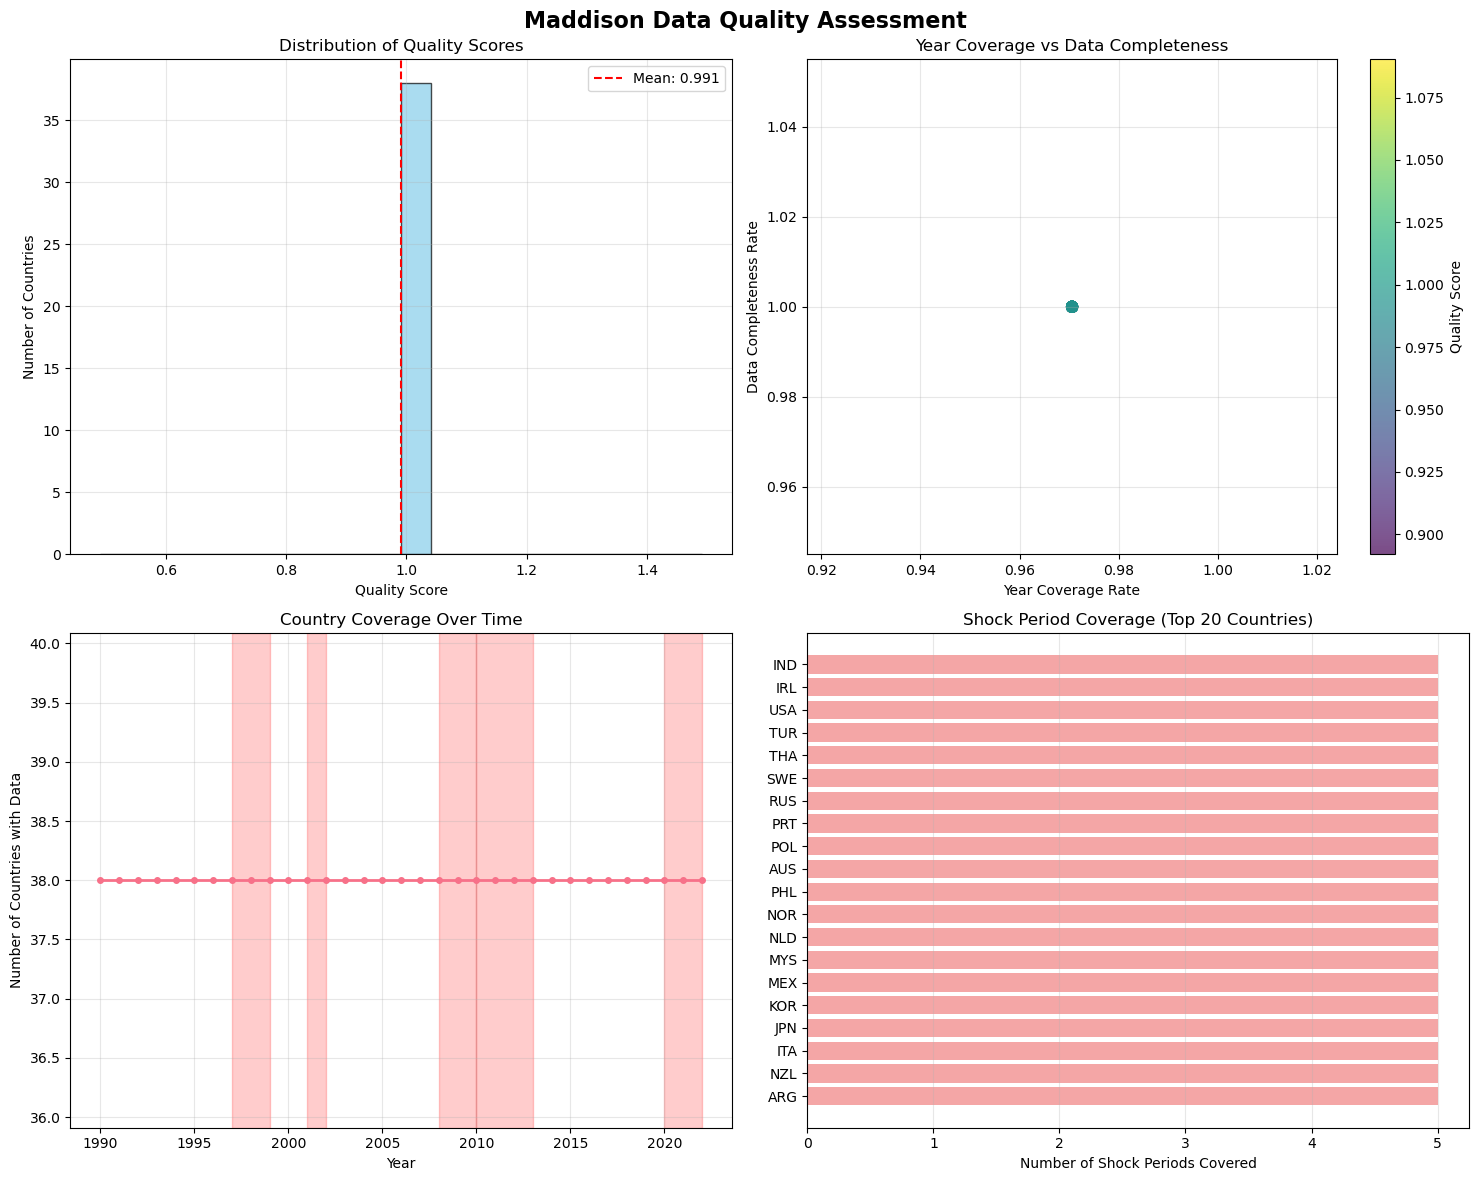

 Visualization complete


In [8]:
# Create visualizations of data coverage for Madisson Project Data

if maddison_data is not None and 'quality_df' in locals():
    print("DATA COVERAGE VISUALIZATIONS")
    print("=" * 40)
    
    # Set up the plotting
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Maddison Data Quality Assessment', fontsize=16, fontweight='bold')
    
    # 1. Quality Score Distribution
    axes[0, 0].hist(quality_df['quality_score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(quality_df['quality_score'].mean(), color='red', linestyle='--', 
                       label=f'Mean: {quality_df["quality_score"].mean():.3f}')
    axes[0, 0].set_title('Distribution of Quality Scores')
    axes[0, 0].set_xlabel('Quality Score')
    axes[0, 0].set_ylabel('Number of Countries')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Year Coverage vs Data Completeness
    scatter = axes[0, 1].scatter(quality_df['year_coverage'], quality_df['overall_completeness'], 
                                c=quality_df['quality_score'], cmap='viridis', alpha=0.7, s=60)
    axes[0, 1].set_title('Year Coverage vs Data Completeness')
    axes[0, 1].set_xlabel('Year Coverage Rate')
    axes[0, 1].set_ylabel('Data Completeness Rate')
    axes[0, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[0, 1], label='Quality Score')
    
    # 3. Countries by data availability over time
    yearly_coverage = maddison_data.groupby('year')['country_code'].nunique()
    axes[1, 0].plot(yearly_coverage.index, yearly_coverage.values, marker='o', linewidth=2, markersize=4)
    axes[1, 0].set_title('Country Coverage Over Time')
    axes[1, 0].set_xlabel('Year')
    axes[1, 0].set_ylabel('Number of Countries with Data')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add shock periods as vertical lines
    for shock_name, shock_info in MAJOR_SHOCKS.items():
        axes[1, 0].axvspan(shock_info['start'], shock_info['end'], alpha=0.2, color='red')
    
    # 4. Shock Coverage by Country
    top_countries = quality_df.head(20)  # Top 20 countries
    axes[1, 1].barh(range(len(top_countries)), top_countries['shock_coverage'], 
                    color='lightcoral', alpha=0.7)
    axes[1, 1].set_yticks(range(len(top_countries)))
    axes[1, 1].set_yticklabels(top_countries['country_code'])
    axes[1, 1].set_title('Shock Period Coverage (Top 20 Countries)')
    axes[1, 1].set_xlabel('Number of Shock Periods Covered')
    axes[1, 1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    print(" Visualization complete")

In [9]:
# Generate comprehensive Summary for Maddison Project Data

if maddison_data is not None and 'quality_df' in locals():
    print("TEST SUMMARY & RECOMMENDATIONS")
    print("=" * 50)
    
    # Overall metrics
    high_quality_countries = quality_df[quality_df['meets_criteria']]['country_code'].tolist()
    medium_quality_countries = quality_df[
        (quality_df['quality_score'] >= 0.6) & (~quality_df['meets_criteria'])
    ]['country_code'].tolist()
    
    print(f"OVERALL RESULTS:")
    print(f"   High-quality countries: {len(high_quality_countries)}")
    print(f"   Medium-quality countries: {len(medium_quality_countries)}")
    print(f"   Dataset shape: {maddison_data.shape}")
    print(f"   Time coverage: {maddison_data['year'].min()}-{maddison_data['year'].max()}")
    
    print(f"\n HIGH-QUALITY COUNTRIES FOR ANALYSIS:")
    print(f"   {', '.join(high_quality_countries)}")
    
    if medium_quality_countries:
        print(f"\n MEDIUM-QUALITY COUNTRIES (consider inclusion):")
        print(f"   {', '.join(medium_quality_countries)}")
    
    # Recommendations
    print(f"\n RECOMMENDATIONS:")
    
    if len(high_quality_countries) >= 30:
        print(f"   Excellent foundation with {len(high_quality_countries)} high-quality countries")
        print(f"   Ready to proceed to World Bank data collection")
        print(f"   Strong coverage across shock periods")
        ready_for_next_phase = True
    elif len(high_quality_countries) >= 25:
        print(f"   Good foundation with {len(high_quality_countries)} countries")
        print(f"   Consider including some medium-quality countries")
        print(f"   Can proceed to World Bank collection with adjustments")
        ready_for_next_phase = True
    else:
        print(f"   Only {len(high_quality_countries)} high-quality countries found")
        print(f"   Consider relaxing quality criteria or expanding country list")
        print(f"   May need to adjust approach before proceeding")
        ready_for_next_phase = False
    
    print(f" NEXT STEPS:")
    if ready_for_next_phase:
        print(f"   1. Proceed to World Bank data collection")
        print(f"   2. Feature engineering with {len(high_quality_countries)} countries")
        print(f"   3. Advanced modeling and analysis")
    else:
        print(f"   1. Review and adjust country selection criteria")
        print(f"   2. Consider alternative data sources")
        print(f"   3. Re-run collection with refined approach")
    
    # Save results for next phase
    print(f"\n SAVING RESULTS:")
    
    # Save the data
    maddison_data.to_csv('data/maddison_focused_test.csv', index=False)
    quality_df.to_csv('data/maddison_quality_assessment.csv', index=False)
    
    # Save country recommendations
    recommendations = {
        'high_quality_countries': high_quality_countries,
        'medium_quality_countries': medium_quality_countries,
        'recommended_for_analysis': high_quality_countries + medium_quality_countries[:5],  # Top 5 medium
        'test_date': datetime.now().isoformat(),
        'ready_for_next_phase': ready_for_next_phase
    }
    
    with open('data/country_recommendations.json', 'w') as f:
        json.dump(recommendations, f, indent=2)
    
    print(f"   Maddison data saved: data/maddison_focused_test.csv")
    print(f"   Quality assessment saved: data/maddison_quality_assessment.csv")
    print(f"   Recommendations saved: data/country_recommendations.json")
    
else:
    print(" COLLECTION FAILED - Cannot generate summary")
    print("   Please review error messages above and fix issues")

print(f"\n MADISSON FOCUSED COLLECTION COMPLETE!")

TEST SUMMARY & RECOMMENDATIONS
OVERALL RESULTS:
   High-quality countries: 38
   Medium-quality countries: 0
   Dataset shape: (1254, 6)
   Time coverage: 1990-2022

 HIGH-QUALITY COUNTRIES FOR ANALYSIS:
   ARG, NZL, ITA, JPN, KOR, MEX, MYS, NLD, NOR, PHL, AUS, POL, PRT, RUS, SWE, THA, TUR, USA, IRL, IND, IDN, HUN, AUT, BEL, BRA, CAN, CHE, CHL, CHN, COL, CZE, DEU, DNK, ESP, FIN, FRA, GBR, ZAF

 RECOMMENDATIONS:
   Excellent foundation with 38 high-quality countries
   Ready to proceed to World Bank data collection
   Strong coverage across shock periods
 NEXT STEPS:
   1. Proceed to World Bank data collection
   2. Feature engineering with 38 countries
   3. Advanced modeling and analysis

 SAVING RESULTS:
   Maddison data saved: data/maddison_focused_test.csv
   Quality assessment saved: data/maddison_quality_assessment.csv
   Recommendations saved: data/country_recommendations.json

 MADISSON FOCUSED COLLECTION COMPLETE!
